[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//IIS-KI-Tutorials/KI-Tutorials/blob/main/automl/2_Kugellager_Klassifikation.ipynb)

# Fehlerhafte Kugellager - Klassifikation auf Zeitreihendaten

Dieses Notebook zeigt ein einfaches Beispiel, wie man mittels AutoML Klassifikation auf Zeitreihendaten betreibt. Ziel ist es, verschiedene Fehlertypen zu klassifizieren, welche bei einem Kugellager auftreten.

## Inhaltsverzeichnis
1. [Imports](#1)<br/>
2. [Laden der Daten](#2)<br/>
3. [Fenstern der Daten und Berechnen von Merkmalen](#3)<br/>
4. [Unterteile die Daten in Trainings- und Testdaten](#4)<br/>
5. [Modell Training](#5)<br/>
6. [Modell Test](#6)<br/>
7. [Modell Interpretation](#7)<br/>
8. [Modell exportieren/speichern](#8)<br/>
9. [Modell laden](#9)<br/>
10. [Vorhersagen für neue Daten](#10)<br/>
11. [Weiterführende Aufgaben](#11)<br/>

### 1 Imports <a class="anchor" id="1"></a>

In [1]:
# --- 3rd party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# --- MDZ Augsburg ---
from utils import get_windows, train_test_split_stratified

### 2 Laden der Daten <a class="anchor" id="2"></a>

Bearing Data Center vom CWRU

Original-Datensatz: [https://engineering.case.edu/bearingdatacenter/download-data-file](https://engineering.case.edu/bearingdatacenter/download-data-file)

![](../assets/CWRU_ilustration.png)

Diese Motorlagerexperimente wurden initiiert, um die Leistung von IQ PreAlert, einem bei Rockwell entwickelten Motorlager-Zustandsbewertungssystem, zu charakterisieren. Experimente wurden unter Verwendung eines 2-PS-Reliance-Elektromotors durchgeführt, und Beschleunigungsdaten wurden an Antriebs- und Lüftungsseite der Motorlager gemessen. Diese Motorlager wurden durch Elektroentladungsbearbeitung (EDM) mit Fehlern übersät. Fehler im Bereich von 0,007 Zoll Durchmesser bis 0,040 Zoll Durchmesser wurden separat an der inneren Laufbahn, dem Walzkörper (d. h. der Kugel) und der äußeren Laufbahn eingeführt. Fehlerhafte Lager wurden wieder in den Testmotor eingebaut und Vibrationsdaten mit einer Frequenz von 12 kHz aufgezeichnet.

Die Sensoren sind:
* Antriebsseite: acc0
* Lüftungsseite: acc1

Die Recording IDs sind wie folgt aufgebaut:
* Der erste Wert gibt den Ort des Fehlers an:
    * none: Kein Fehler
    * OR: Outer Race (Außenbahn)
    * IR: Inner Race (Innenbahn)
    * BA: Ball (Kugel)
* Der Zahlenwert definiert die Schwere des Fehlers (bzw. den Durchmesser):
    * 00: Kein Fehler
    * 07: 0.007''
    * 14: 0.014''
    * 21: 0.021''

Wir laden die Daten als sog. DataFrame und speichern sie in der Variablen `data`.

Der Datensatz beinhaltet mehr als 1,5 Mio. Messpunkte (Instanzen).
Neben der Zeitspalte sehen wir die beiden Beschleunigungssensoren ("acc0" und "acc1") sowie die Spalte "recording_id".
Es gibt insgesamt 10 verschiedene recording_ids, von denen jede eine einzelne Messung repräsentiert.
Da pro Messung immer nur ein bestimmter Fehler vorhanden war, entspricht dies im Grunde der Label-Spalte.

In [2]:
data = pd.read_csv("../datasets/CWRU.csv")
data

,time,acc0,acc1,recording_id
0,0.000000,0.105420,0.204633,BA_14
1,0.000083,-0.107370,0.248395,BA_14
2,0.000167,-0.163410,0.042324,BA_14
3,0.000250,0.118903,-0.015615,BA_14
4,0.000333,0.184039,-0.058555,BA_14
...,...,...,...,...
1584628,10.165583,-0.156344,0.063691,IR_21
1584629,10.165667,1.099280,-0.059376,IR_21
1584630,10.165750,0.231876,-0.080949,IR_21
1584631,10.165833,-1.241410,0.110945,IR_21


In [3]:
unique_recording_ids = sorted(data['recording_id'].unique())
print(f'Liste der vorkommenden recording_ids bzw. Label:\n\n{", ".join(unique_recording_ids)}')

Liste der vorkommenden recording_ids bzw. Label:

BA_07, BA_14, BA_21, IR_07, IR_14, IR_21, OR_07, OR_14, OR_21, none_00


### 3 Fenstern der Daten und Berechnen von Merkmalen <a class="anchor" id="3"></a>
In diesem Beispiel handelt es sich um sog. Zeitreihendaten, die mit einer Frequenz von 12 kHz aufgenommen wurden.
Ein einzelner Messpunkt für sich trägt hierbei keine wertvolle Information, sondern vielmehr ist die Abfolge von Messpunkten im zeitlichen Kontext interessant und für das entsprechende Label charakteristisch.

Im Folgenden wollen wir also zunächst die vorhandenen Rohdaten fenstern. Hierzu ist es notwendig eine Fenstergröße zu definieren (window_length). Anschließend werden statistische Merkmale (Minimum, Maximum, Mittelwert, ...) auf den Daten innerhalb der jeweiligen Fenster berechnet. Je nach recording_id ist jedem Fenster außerdem auch ein Label zugeordnet.

In [4]:
window_length = 0.1 # in seconds

window_size = round(window_length * 12000) # 12000/s ist die Abtastrate der Sensoren
feature_names = ['min', 'max', 'range', 'mean', 'median']
sensors = ['acc0', 'acc1']
feature_dict = {f'{sensor}_{feature_name}': [] for sensor in sensors for feature_name in feature_names}
feature_dict['label'] = []

for recording_id in data['recording_id'].unique():
    for sensor in sensors:
        windowed_data = get_windows(data[data['recording_id'] == recording_id][sensor].values, window_size, window_size)

        feature_dict[f'{sensor}_min'] += [min(row) for row in windowed_data]
        feature_dict[f'{sensor}_max'] += [max(row) for row in windowed_data]
        feature_dict[f'{sensor}_range'] += list(np.array([min(row) for row in windowed_data]))
        feature_dict[f'{sensor}_mean'] += [np.mean(row) for row in windowed_data]
        feature_dict[f'{sensor}_median'] += [np.median(row) for row in windowed_data]
        
    feature_dict['label'] += [recording_id for i in range(len(windowed_data))]

data_features = pd.DataFrame.from_dict(feature_dict)

In der folgenden Zelle sehen wir nun das Resultat unserer Merkmalsberechnung. Jede Zeile der Tabelle repräsentiert nun ein vorher ausgeschnittenes Fenster (von vorher definierter Länge) auf dem verschiedene statistische Merkmale berechnet wurden. Die Spalten stehen für eben jene berechneten Merkmale. Die letzte Spalte zeigt das dem Fenster zugeordnete Label.

In [5]:
data_features

,acc0_min,acc0_max,acc0_range,acc0_mean,acc0_median,acc1_min,acc1_max,acc1_range,acc1_mean,acc1_median,label
0,-0.462940,0.461153,-0.462940,0.004501,0.001218,-0.371256,0.443987,-0.371256,0.031285,0.036263,BA_14
1,-0.409012,0.475935,-0.409012,0.004824,0.005685,-0.364887,0.426729,-0.364887,0.032116,0.032565,BA_14
2,-1.048844,1.105858,-1.048844,0.004549,0.003574,-0.389953,0.474189,-0.389953,0.031660,0.035338,BA_14
3,-0.830206,0.733395,-0.830206,0.004575,0.008853,-0.568904,0.537880,-0.568904,0.031400,0.034619,BA_14
4,-0.365154,0.464889,-0.365154,0.004456,0.005279,-0.347835,0.405362,-0.347835,0.032805,0.035441,BA_14
...,...,...,...,...,...,...,...,...,...,...,...
1310,-2.438151,2.682616,-2.438151,0.001187,-0.006091,-0.742718,0.798396,-0.742718,0.030567,0.029894,IR_21
1311,-2.190844,2.725255,-2.190844,0.003245,-0.008122,-0.782371,0.657455,-0.782371,0.031778,0.031640,IR_21
1312,-2.058459,2.397136,-2.058459,0.002297,-0.005076,-0.646976,0.750525,-0.646976,0.031111,0.024141,IR_21
1313,-2.680992,3.030633,-2.680992,0.002782,-0.005482,-0.713338,0.710462,-0.713338,0.032110,0.035030,IR_21


### 4 Unterteile die Daten in Trainings- und Testdaten <a class="anchor" id="4"></a>
Nun unterteilen wir unseren Datensatz in Trainings- und Testdaten.

80% der Daten werden als Trainingsdaten und 20% als Testdaten ausgewählt. Das AutoML Framework wird also lediglich die Trainingsdaten für das Training und Validieren von Modellen benutzen. Mit den Testdaten wird das finale Modell abschließend getestet, um seine Genauigkeit angeben zu können.

Die Daten werden hierbei so getrennt, dass die Verteilung der Label sowohl in Trainings- als auch Testset der Verteilung der Label in den Gesamtdaten entspricht.

In [6]:
data_train, data_test = train_test_split_stratified(data_features, test_size=0.2, label_colname='label')

### 5 Modell Training <a class="anchor" id="5"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `TabularPredictor` und speichern diese in der Variablen `predictor`.
Hier müssen wir lediglich den Namen des Labels angeben.
Optional kann man auch den Pfad angeben, in dem sämtliche Modelle gespeichert werden sollen (hier: "AutogluonModels/Kugellager").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>"  erstellt, in dem die Modelle gespeichert werden.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten viele verschiedene Modelle und gibt automatisch das beste Ensemble-Modell zurück.
Dieses speichern wir in der `predictor` Variable.

Es sei zu beachten, dass das Framework automatisch erkennt, dass es sich um ein Klassifikationsproblem handelt.

In [7]:
predictor = TabularPredictor(label='label', path='AutogluonModels/Kugellager')
predictor.fit(data_train);

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/Kugellager\"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    1054
Train Data Columns: 10
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	10 unique label values:  ['BA_07', 'none_00', 'IR_07', 'BA_14', 'IR_14', 'OR_21', 'OR_07', 'IR_21', 'BA_21', 'OR_14']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 10
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5634.59 MB
	Train Data (Original)  Memory Usage: 0.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set fea

Mit der `fit_summary()` Methode können wir uns eine Zusammenfassung und Übersicht der trainierten Modelle anzeigen lassen. Die zweite Spalte zeigt hier den jeweiligen "score_val", sprich die Genauigkeit (engl.: accuracy) auf den Validierungsdaten. Nach diesem Wert sind auch die Modelle absteigend sortiert. Das gewichtete Ensemble hat also die besten Ergebnisse erzielt.

Es wird zudem ein Diagramm erstellt, in dem die Inferenzzeit und die Modellgenauigkeit gegenübergestellt werden. Dieses wird im Pfad "AutogluonModels/Kugellager/SummaryOfModels.html" abgespeichert und kann in einem Browser geöffnet werden.

In [8]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.981043       0.044962   6.603499                0.001000           0.344003            2       True         14
1               XGBoost   0.976303       0.008961   1.311018                0.008961           1.311018            1       True         11
2         LightGBMLarge   0.971564       0.020005   5.908095                0.020005           5.908095            1       True         13
3            LightGBMXT   0.971564       0.024008   3.521878                0.024008           3.521878            1       True          4
4              LightGBM   0.962085       0.022004   3.557263                0.022004           3.557263            1       True          5
5       NeuralNetFastAI   0.962085       0.035002   4.948477                0.035002           4.948477 

### 6 Modell Test <a class="anchor" id="6"></a>
Zum Testen und Evaluieren des finalen Modells verwenden wir die vorab separierten Testdaten.
Mit der `evaluate` Methode können wir eine Reihe von Qualitätsmaßen berechnen.

In [9]:
pred_metrics = predictor.evaluate(data_test)

Evaluation: accuracy on test data: 0.9540229885057471
Evaluations on test data:
{
    "accuracy": 0.9540229885057471,
    "balanced_accuracy": 0.9399999999999998,
    "mcc": 0.9463219985617793
}


Hier sehen wir abermals eine Überischt aller trainierten Modelle. Die Tabelle beinhaltet jetzt auch die Spalte 'score_test'. Diese zeigt die jeweilige Genauigkeit (engl.: accuracy) auf dem Testdatensatz, also wie viel Prozent der Instanzen richtig klassifiziert worden sind.

In [10]:
predictor.leaderboard(data_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.973180,0.943128,0.127160,0.073927,0.825888,0.127160,0.073927,0.825888,1,True,10
1,RandomForestEntr,0.969349,0.952607,0.136004,0.083998,0.755808,0.136004,0.083998,0.755808,1,True,7
2,ExtraTreesGini,0.965517,0.962085,0.107426,0.077703,0.976577,0.107426,0.077703,0.976577,1,True,9
3,LightGBM,0.961686,0.962085,0.076001,0.022004,3.557263,0.076001,0.022004,3.557263,1,True,5
4,LightGBMXT,0.961686,0.971564,0.103001,0.024008,3.521878,0.103001,0.024008,3.521878,1,True,4
5,RandomForestGini,0.961686,0.957346,0.119519,0.082004,0.848029,0.119519,0.082004,0.848029,1,True,6
6,NeuralNetFastAI,0.954023,0.962085,0.067000,0.035002,4.948477,0.067000,0.035002,4.948477,1,True,3
7,WeightedEnsemble_L2,0.954023,0.981043,0.093997,0.044962,6.603499,0.009000,0.001000,0.344003,2,True,14
8,CatBoost,0.938697,0.952607,0.008962,0.001999,10.244659,0.008962,0.001999,10.244659,1,True,8
9,LightGBMLarge,0.938697,0.971564,0.260005,0.020005,5.908095,0.260005,0.020005,5.908095,1,True,13


Nun wollen wir uns etwas detailliertere Ergebnisse anschauen.

Dazu benutzen wir zunächst die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der Variable `y_pred`. Die tatsächlichen Label speichern wir in der Variable `y_true`.

In [11]:
y_pred = predictor.predict(data_test)
y_true = data_test['label']

Mit Hilfe von `y_pred` und `y_true` können wir uns nun einen Klassifikations-Report ausgeben lassen. Dieser beinhaltet nicht nur die globale Genauigkeit (accuracy), sondern zeigt auch jeweils die Relevanz (precision), die Sensitivität (recall) sowie den F1-Score für alle vorkommenden Klassen im Datensatz an. Die support Spalte gibt an, wie viele Instanzen der jeweiligen Klasse sich im Testdatensatz befinden. 

In [12]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

       BA_07       0.88      0.70      0.78        20
       BA_14       0.72      0.90      0.80        20
       BA_21       1.00      1.00      1.00        20
       IR_07       1.00      1.00      1.00        20
       IR_14       1.00      0.95      0.97        20
       IR_21       1.00      1.00      1.00        20
       OR_07       0.95      0.90      0.92        20
       OR_14       1.00      1.00      1.00        20
       OR_21       0.90      0.95      0.93        20
     none_00       1.00      1.00      1.00        81

    accuracy                           0.95       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.96      0.95      0.95       261



Eine zusätzliche Möglichkeit, die Ergebnisse detailliert zu visualisieren bietet die sog. Konfusionsmatrix.
Entlang der x-Achse sehen wir die vom Modell gemachten Vorhersagen, auf der y-Achse die tatsächlichen Label.

Im Feld links oben (1. Zeile, 1. Spalte) steht also die Anzahl der Instanzen in den Traingsdaten, bei denen tatsächlich ein 0.007'' Fehler an einer Kugel vorlag und dies von unserem Modell auch so vorhergesagt wurde.

Im Feld darunter (2. Zeile, 1. Spalte) steht die Anzahl der Instanzen, bei denen tatsächlich ein ein 0.014'' Fehler an einer Kugel vorlag, unser Modell aber fälschlicherweise einen 0.007'' Fehler vorhergesagt hat.

Eine Konfusionsmatrix eignet sich somit schnell zu erkennen, welche Klassen untereinander verwechselt werden.
Liegen viele Instanzen auf der Diagonalen, so spricht dies für ein gutes Modell. Hier decken sich die Vorhersagen mit den tatsächlichen Werten.

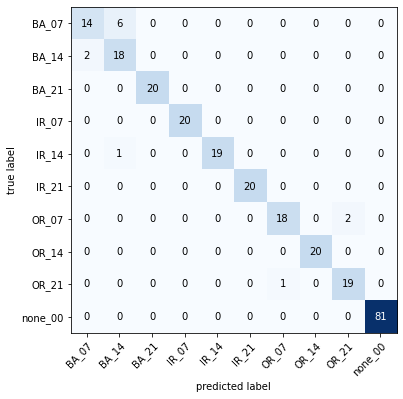

In [13]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix(cm, figsize=(6, 6), show_absolute=True, show_normed=False, class_names=predictor.class_labels)

### 7 Modell Interpretation <a class="anchor" id="7"></a>
In der folgenden Zelle wird die sog. Merkmalswichtigkeit (engl.: feature importance) berechnet und aufgelistet (1. Spalte). Je höher die Wichtigkeit (importance), umso bedeutender und gewichtiger ist der Einfluss des jeweiligen Merkmals zur Bestimmung einer Vorhersage. Dies kann sehr aufschlussreich sein, um zu verstehen welche Merkmale eher wichtig und welche eher unwichtig sind.

In [14]:
predictor.feature_importance(data_test, silent=True)

,importance,stddev,p_value,n,p99_high,p99_low
acc0_mean,0.262835,0.012591,6.300928e-07,5,0.288761,0.236910
acc1_min,0.183908,0.021842,2.343466e-05,5,0.228882,0.138934
acc0_min,0.170881,0.024623,5.032848e-05,5,0.221580,0.120183
acc1_max,0.114943,0.016480,4.934346e-05,5,0.148874,0.081011
acc0_max,0.114176,0.011301,1.136849e-05,5,0.137445,0.090907
acc0_median,0.022989,0.008128,1.599101e-03,5,0.039723,0.006254
acc0_range,0.013793,0.006411,4.290459e-03,5,0.026994,0.000592
acc1_range,0.010728,0.006854,1.244808e-02,5,0.024840,-0.003384
acc1_median,0.010728,0.009917,3.642753e-02,5,0.031148,-0.009692
acc1_mean,0.008429,0.003206,2.090536e-03,5,0.015029,0.001829


### 8 Modell exportieren/speichern <a class="anchor" id="8"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es gespeichert werden. Dies geschieht schon automatisch beim Modell Training. Bei Bedarf kann man jedoch auch im Nachhinhein das Modell mittels der `save()` Methode speichern (optional unter Angabe eines Pfades der Wahl).

In [15]:
predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/Kugellager\")


### 9 Modell laden <a class="anchor" id="9"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode auf.

In [16]:
predictor = TabularPredictor.load(path="./AutogluonModels/Kugellager")

### 10 Vorhersagen für neue Daten <a class="anchor" id="10"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [17]:
test_window = data_features.sample()
test_window

,acc0_min,acc0_max,acc0_range,acc0_mean,acc0_median,acc1_min,acc1_max,acc1_range,acc1_mean,acc1_median,label
1138,-3.374996,3.301088,-3.374996,0.002744,0.005076,-0.977758,1.255533,-0.977758,0.031145,0.033284,OR_21


In [18]:
prediction = predictor.predict(test_window)
print(f'Vorhergesagte Klasse: {", ".join(prediction.values)}')

Vorhergesagte Klasse: OR_21


### 11 Aufgaben <a class="anchor" id="11"></a>
1. Welchen Einfluss hat eine kleinere bzw. größere Fensterlänge? Überlegen Sie sich zunächst welche Veränderung Sie erwarten würden und überprüfen Sie diese anschließend, indem Sie verschiedene Werte ausprobieren. Passen Sie dazu den Wert der Variable `window_length` unter [3 Fenstern der Daten und Berechnen von Merkmalen](#3) entsprechend an.
2. Außer den Trainingsdaten und der Angabe des Labels benötigt AutoGluon keinen weiteren Input zum Trainieren eines Modells. Es ist jedoch möglich weitere Parameter anzupassen, um den Trainingsprozess zu beeinflussen. Eine sehr praktische Möglichkeit dafür ist der Parameter `presets` der `fit()`-Methode. Informieren Sie sich zunächst dazu in der [Dokumentation von AutoGluon](https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit) und probieren sie anschließend verschiedene `presets` aus. Passen Sie dazu den Code unter [5 Modell Training](#3) entsprechend an. Welche Veränderungen beim Trainingsprozess und bei den resultierenden Modellen können Sie feststellen?
3. Überlegen Sie, ob Sie ähnliche Anwendungsfälle in Ihrem Unternehmen identifizieren können, für die die Zeitreihenklassifizierung eine Möglichkeit zur Verbesserung bzw. Automatisierung bieten könnte.